# Tinytol apperture design
---
### 15mm apperture testing
#### Single half wave step at 525nm (central green band)
**What is the ideal pupil design that gives a central peak brighness equal to that of the outer peaks (bed of nails)**

1/10$^{th}$ of a wavelength singusoidal grating (only a single dimension)

use spiral phase plate to invert sinusoidal function

central region should be ~1/10$^{th}$ total pupil size

In [2]:
# Add local scripts to module search path
import sys
import matplotlib.pyplot as plt
import numpy as np
import proper
proper.print_it = False
from pathlib import Path
path = str(Path().resolve())
sys.path.append((path[0:len(path)-len("notebooks/TinyTol")]) + "toliman-proper")
from math import sin, log10, cos, atan2, hypot
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
from prescription_quad import prescription_quad
from proper_tools import form_detector_image
from FT_model import model_FT
from get_wf import get_wf
from copy import deepcopy

prescription = 'prescription_quad'
image_path = "Images/"

def binarized_ringed_flipped(r, phi, phase, thresh=0.0, white=0, empty=0., r_max=300., r_min=50., r_split=246.):
        
    # Spiral parameters
    alpha1 = 20.186
    m1 = 5
    eta1 = -1.308
    m2 = -5
    alpha2 = 16.149
    eta2 = -0.733
    m3 = 10
    alpha3 = 4.0372
    eta3 = -0.575    

    s = 0.1501/300. # m/internal sampling dist

    black = phase
    v = empty
    r = r/s
    if (r<=r_max and r>r_min):
        logr = log10(r)
        chi1 = alpha1*logr+m1*phi+eta1
        c1 = cos(chi1)
        chi2 = alpha2*logr+m2*phi+eta2
        c2 = cos(chi2)
        chi3 = alpha3*logr+m3*phi+eta3
        c3 = sin(chi3)
        if (r>r_split): # Outer rim
            if (c3<thresh):
                v=black if (c1*c2*c3>thresh) else white
            else:
                if (sin(chi3/2.)>thresh):
                    v = black
                else:
                    v=black if (c1*c2*c3>thresh) else white 
        else: # Main spiral
            v=black if (c1*c2*c3>thresh) else white
    else:
        v = black
    return v

/Users/louis/.local/lib/python3.7/site-packages/pyfits-3.5-py3.7-macosx-10.7-x86_64.egg/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [3]:
fl = 0.15                        # Focal length (m)
app = 0.015                      # Apperture (m)
detector_pitch = 1.12e-6         # m/pixel on detector (pixel spacing)
gridsize = 2048                  # size of the grid that the simulation is run on
npixels = 1024                   # Size of detector, in pixels
ratio = 0.5                      # ratio  of gridsize to appreture size (ignore)
wl_vals = [0.525]                # Wavelength values (micrometers)
wl_weights = [1.]                # Wavelength relative intensities

phase = 525                      # Has units of nm
r_max = 15
r_min = 3.02
r_split = 12.5

def generate_pupil(r, phi, phase=phase, r_max=r_max, r_min=r_min, r_split=r_split):
    phase = phase*1e-9*0.5
    return binarized_ringed_flipped(r, phi, phase, r_max=r_max, r_min=r_min, r_split=r_split)

spiral = generate_pupil          # Spiral function to be run

tinytol_settings = {
                    'diam': app,                # telescope diameter in meters
                    'm1_fl': fl,                # primary focal length (m)
                    'beam_ratio': ratio,        # Initial beam width/grid width
                    'opd_func': spiral
                    }  

mask_size = tinytol_settings['diam']
foc_length = tinytol_settings['m1_fl']
chip_dim = npixels
pix_size = detector_pitch

source = {
            'wavelengths': wl_vals,
            'weights': wl_weights,
            'settings': tinytol_settings
            }

sources = [source]

In [4]:
%%time

tinytol_settings['get_wf'] = True
tinytol_settings['beam_ratio'] = 0.99
wfo, wf, sampling = prescription_quad(wl_vals[0]*1e-6,gridsize,PASSVALUE=tinytol_settings)
tinytol_settings['get_wf'] = False
tinytol_settings['beam_ratio'] = ratio

Got wavefront
CPU times: user 8.86 s, sys: 295 ms, total: 9.15 s
Wall time: 8.04 s


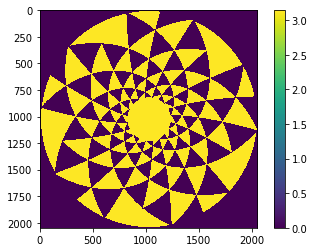

In [5]:
plt.imshow(np.abs(np.angle(wf)))
plt.colorbar()
plt.show()

In [6]:
%%time

new_mask = deepcopy(wf)
size = gridsize
# cycles = 64
cycles = 128 # 128 gives more power in the 0th fringe 
a = size//cycles
ratio = 1/10

for y in range(size):
    for x in range(size):        
        if np.abs(new_mask[y][x]) > 0:
            if np.angle(new_mask[y][x]) < -0.1:
                if x%a <= a*ratio or y%a <= a*ratio:
                    new_mask[y][x] = np.complex(1,0)
                else:
                    new_mask[y][x] = -np.complex(1,0)
            else:
                if (x+(a//2))%a <= a*ratio or (y+(a//2))%a <= a*ratio:
                    new_mask[y][x] = -np.complex(1,0)
                else:
                    new_mask[y][x] = np.complex(1,0)

CPU times: user 20.3 s, sys: 31.5 ms, total: 20.3 s
Wall time: 20.2 s


In [29]:
print(np.angle(np.complex(1,0)))
print(np.angle(-np.complex(1,0)))

0.0
-3.141592653589793


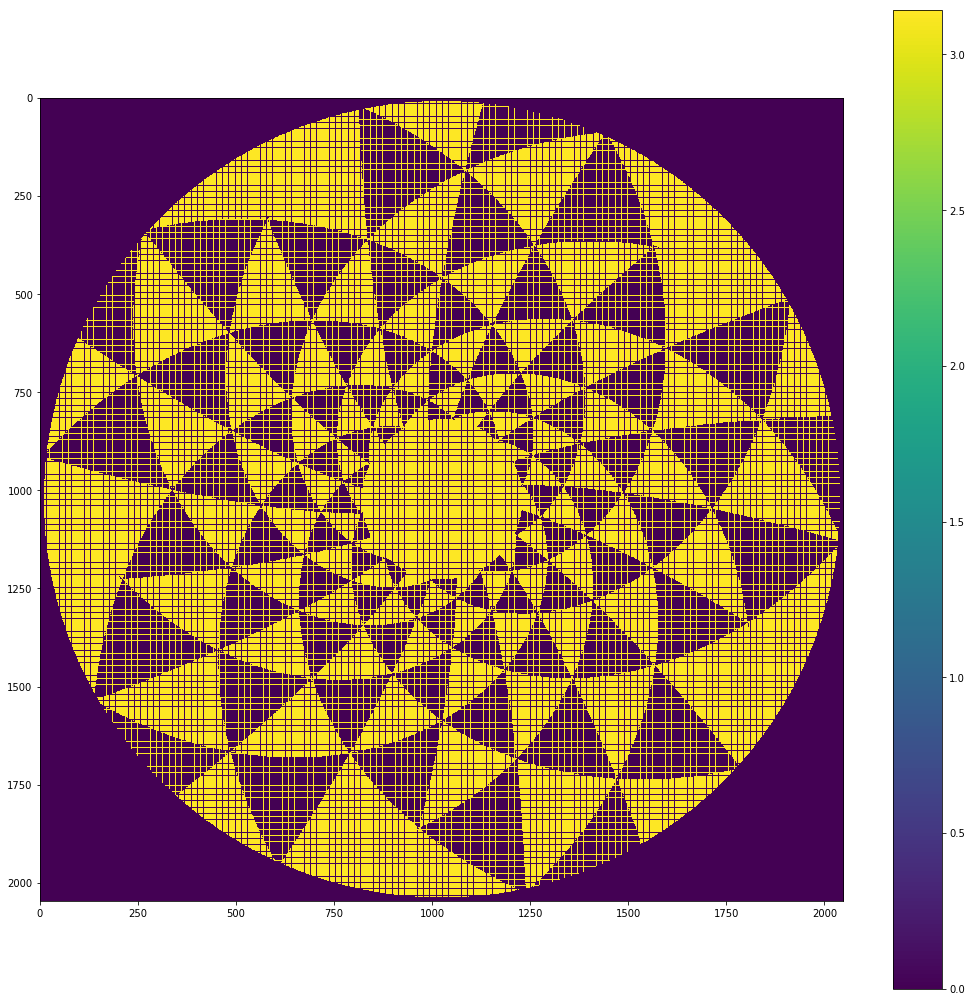

In [7]:
plt.figure(figsize=(18,18))
plt.imshow(np.abs(np.angle(new_mask)))
# plt.imshow(np.abs(new_mask))
plt.colorbar()
plt.show()

In [8]:
%%time
# proper = form_detector_image(prescription, sources, gridsize, detector_pitch, npixels)
mask = deepcopy(wf)
new_FT = model_FT(new_mask, mask_size, chip_dim, [wl_vals[0]*1e-6], foc_length, pix_size)
# FT = model_FT(mask, mask_size, chip_dim, [wl_vals[0]*1e-6], foc_length, pix_size)

CPU times: user 12.8 s, sys: 4.44 s, total: 17.3 s
Wall time: 11.4 s


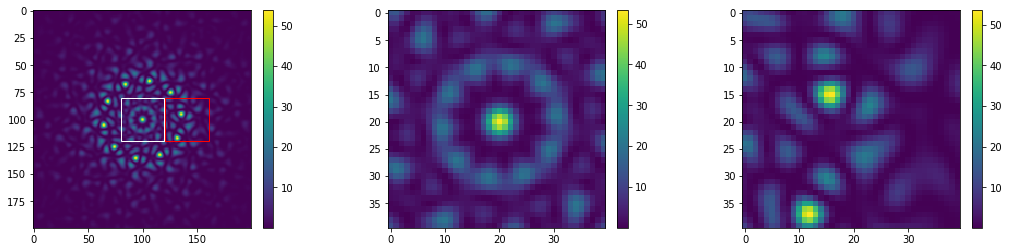

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
size = 200
# size = 1024

# FT_out = FT*1e5/np.sum(FT)
# c = FT_out.shape[0]/2

FT_out = new_FT*1e5/np.sum(new_FT)
c = FT_out.shape[0]/2

im_out = FT_out[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]
im = axs[0].imshow(im_out)
# im = axs[0].imshow(im_out, norm=LogNorm())
plt.colorbar(im,ax=axs[0],fraction=0.046, pad=0.04)

rect = patches.Rectangle((121,80),40,40,linewidth=1,edgecolor='r',facecolor='none')
axs[0].add_patch(rect)
rect = patches.Rectangle((80,80),40,40,linewidth=1,edgecolor='w',facecolor='none')
axs[0].add_patch(rect)

size = 40
ctr_out = FT_out[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]
im = axs[1].imshow(ctr_out)
plt.colorbar(im,ax=axs[1],fraction=0.046, pad=0.04)

offset = 40
cnr_out = FT_out[int(c-size//2):int(c+size//2),int(c-size//2)+offset:int(c+size//2)+offset]
im = axs[2].imshow(cnr_out)
plt.colorbar(im,ax=axs[2],fraction=0.046, pad=0.04)

plt.show()

To find the ideal layout we will introduce a quality factor Q defined as the ratio of the max values of the two image (minus 1) such that our ideal pupil will have a Q value of 0

In [10]:
max_central = ctr_out.max()
max_outer = cnr_out.max()
Q = np.abs(max_central/max_outer - 1)

print("Central peak: {:.2f}".format(max_central))
print("Outer peak: {:.2f}".format(max_outer))
print("Quality factor: {:.6f}".format(Q))

Central peak: 53.24
Outer peak: 53.51
Quality factor: 0.004980


### Find the values that seperate the layers of the pupil

In [396]:
import math
import numpy as np

def generate_spiral(gridsize, aperture, r_max, r_min, r_split):
    sampling = aperture/(gridsize//2)
    wfarr = np.zeros([gridsize, gridsize], dtype = np.complex128)
    c = gridsize//2
    for i in range(gridsize):
        for j in range(gridsize):
            x = i - c
            y = j - c
            phi = math.atan2(y, x)
            r = sampling*math.hypot(x,y)
            wfarr[i][j] = spiral(r, phi, aperture, r_max, r_min, r_split)
    return wfarr

def spiral(r, phi, aperture, r_max, r_min, r_split):
    # Spiral parameters
    alpha1 = 20.186
    m1 = 5
    eta1 = -1.308
    m2 = -5
    alpha2 = 16.149
    eta2 = -0.733
    m3 = 10
    alpha3 = 4.0372
    eta3 = -0.575    
    thresh = 0
    
    white = np.complex(1,0)
    black = -np.complex(1,0)
    v = np.complex(0,0)
    
    offset0 = np.complex(-(3**0.5)/2,1/2)
    offset1 = np.complex(-1**0.5,1**0.5)
    offset2 = np.complex(-1/2,(3**0.5)/2)
    offset3 = np.complex(0,1) 
    offset4 = np.complex(1/2,(3**0.5)/2)
    offset5 = np.complex(1**0.5,1**0.5)
    offset7 = np.complex((3**0.5)/2,1/2)

    if (r<=r_max and r>r_min):
        logr = log10(r)
        chi1 = alpha1*logr+m1*phi+eta1
        c1 = cos(chi1)
        chi2 = alpha2*logr+m2*phi+eta2
        c2 = cos(chi2)
        chi3 = alpha3*logr+m3*phi+eta3
        c3 = sin(chi3)
        if (r>=r_split[0] and r <= r_max):
            
            if (c3<thresh):                                             # The 'first' and 'third' sections of the spiral
                v = black if (c1*c2*c3>thresh) else white
#                 v = offset4 if (c1*c2*c3>thresh) else offset5  
#                 v = black
            else:
                if (sin(chi3/2.)>thresh):                               # The 'second' section of the spiral
                    v = black
#                     v=black if (c1*c2*c3>thresh) else white
#                     v = offset0 if (c1*c2*c3>thresh) else offset1
                else:                                                   # The 'fourth' section of the spiral
#                     v = black
                    v = black if (c1*c2*c3>thresh) else white
#                     v = offset2 if (c1*c2*c3>thresh) else offset3
    
        elif (r>=r_split[1] and r<r_split[0]):
            
            if (c3<thresh):  
                v = black if (c1*c2*c3>thresh) else white
#                 v = offset4 if (c1*c2*c3>thresh) else offset5  
#                 v = black
            else:
                if (sin(chi3/2.)>thresh):
#                     v = black
                    v=black if (c1*c2*c3>thresh) else white
#                     v = offset0 if (c1*c2*c3>thresh) else offset1
                else:
                    v = black if (c1*c2*c3>thresh) else white
#                     v = offset2 if (c1*c2*c3>thresh) else offset3

        elif (r>=r_split[2] and r<r_split[1]):
        
            if (c3<thresh):  
#                 v = black
                v = black if (c1*c2*c3>thresh) else white
#                 v = offset4 if (c1*c2*c3>thresh) else offset5  
            else:
                if (sin(chi3/2.)>thresh):
#                     v = black
                    v=black if (c1*c2*c3>thresh) else white
#                     v = offset0 if (c1*c2*c3>thresh) else offset1
                else:
                    v = black
#                     v = black if (c1*c2*c3>thresh) else white
#                     v = offset2 if (c1*c2*c3>thresh) else offset3
                    
        elif (r>=r_split[3] and r<r_split[2]):
            
            if (c3<thresh):  
                v = black if (c1*c2*c3>thresh) else white
#                 v = offset4 if (c1*c2*c3>thresh) else offset5  
            else:
                if (sin(chi3/2.)>thresh):
#                     v = black
                    v=black if (c1*c2*c3>thresh) else white
#                     v = offset0 if (c1*c2*c3>thresh) else offset1
                else:
                    v = black if (c1*c2*c3>thresh) else white
#                     v = offset2 if (c1*c2*c3>thresh) else offset3

        elif (r>=r_split[4] and r<r_split[3]):
            
            if (c3<thresh):  
                v = black if (c1*c2*c3>thresh) else white
#                 v = offset4 if (c1*c2*c3>thresh) else offset5  
            else:
                if (sin(chi3/2.)>thresh):
                    v = black
#                     v=black if (c1*c2*c3>thresh) else white
#                     v = offset0 if (c1*c2*c3>thresh) else offset1
                else:
                    v = black if (c1*c2*c3>thresh) else white
#                     v = offset2 if (c1*c2*c3>thresh) else offset3

        else: # Main spiral
            v = black if (c1*c2*c3>thresh) else white

    elif r < r_min:
        v = black
    return v

In [397]:
%%time
aperture = 0.015                 # Aperture (m)
npixels = 1024                   # Size of detector, in pixels
wl = 0.525e-9                    # Wavelength values (micrometers)
fl = 0.15                        # Focal length (m)
detector_pitch = 1.12e-6         # m/pixel on detector (pixel spacing)

r_max = 15.15
r_min = 0.62

split_values = [12.4, 8.33, 5.6, 3.75, 2.5, 1.7, 1.14, 0.76]
r_split = split_values[0]
r_split = split_values[:5]
# r_split = [split_values[-1]]

wf = generate_spiral(gridsize, aperture*1e3, r_max, r_min, r_split)

CPU times: user 14.1 s, sys: 30.4 ms, total: 14.1 s
Wall time: 14.2 s


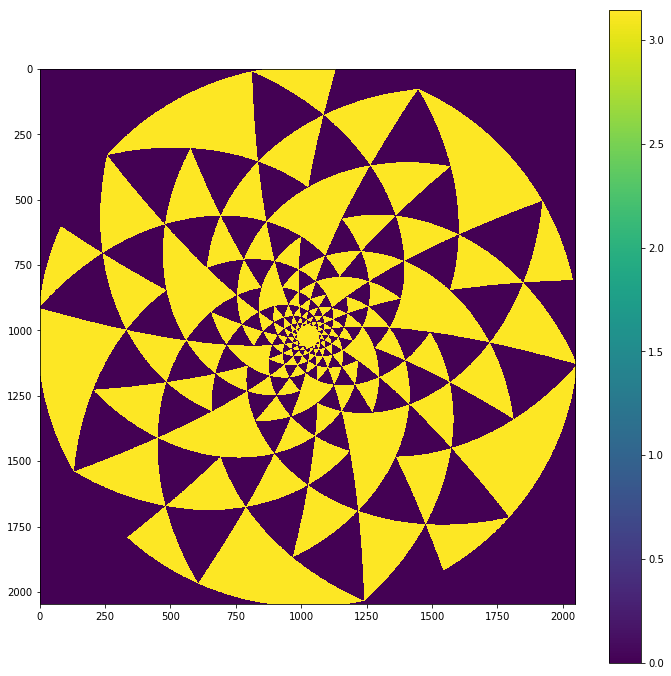

In [398]:
plt.figure(figsize=(12,12))
plt.imshow(np.abs(np.angle(wf)))
plt.colorbar()
plt.show()

In [399]:
%%time
FT = model_FT(wf, aperture*1e-3, npixels, [wl], fl, detector_pitch)

CPU times: user 6.73 s, sys: 4.35 s, total: 11.1 s
Wall time: 9.12 s


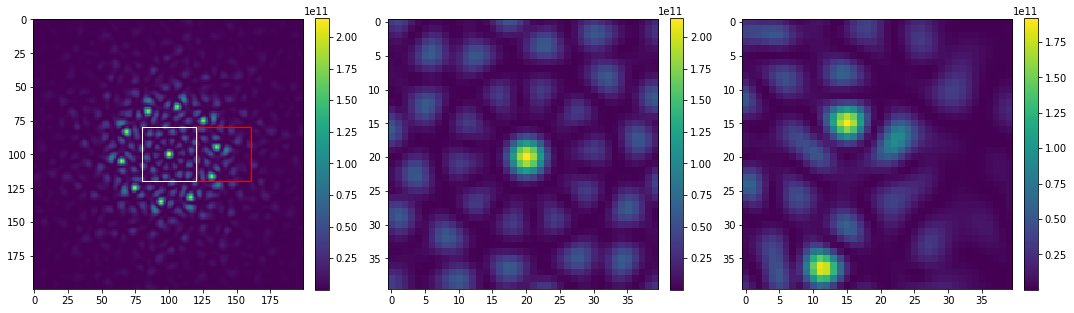

In [431]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
size = 200
# size = 1024

# FT_out = FT*1e5/np.sum(FT)
c = FT.shape[0]/2
FT_out = FT


im_out = FT_out[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]
im = axs[0].imshow(im_out)
# im = axs[0].imshow(im_out, norm=LogNorm())
plt.colorbar(im,ax=axs[0],fraction=0.046, pad=0.04)

rect = patches.Rectangle((121,80),40,40,linewidth=1,edgecolor='r',facecolor='none')
axs[0].add_patch(rect)
rect = patches.Rectangle((80,80),40,40,linewidth=1,edgecolor='w',facecolor='none')
axs[0].add_patch(rect)

size = 40
ctr_out = FT_out[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]
im = axs[1].imshow(ctr_out)
plt.colorbar(im,ax=axs[1],fraction=0.046, pad=0.04)

offset = 40
cnr_out = FT_out[int(c-size//2):int(c+size//2),int(c-size//2)+offset:int(c+size//2)+offset]
im = axs[2].imshow(cnr_out)
plt.colorbar(im,ax=axs[2],fraction=0.046, pad=0.04)

plt.show()

---

General plan moving forward: Break up each ringed region into their own function with a set of 'on and off' switches that turn the different 'quadrants' of the repeating pattern off and on. Then iteratively turning the different regions on and off and trying all the different permutations of the qudrants we should be able to explore the entire parameter space.

note: The size of the inner region of the pupil was chosen to be as small as possible (to be determined later by the precision of the tools that make it) since there is an ~2% leakage of photons that will not see the pupil, this will form the power in the central region of the detector (0th fringe). The size of this inner region can always be adjusted later to direct more power to the central region if neccesary.

---

### Split the image into central and outer region

Create an circular image with some radii to use as the 'cental region' and the rest as the 'outer region'. Optimise for the lowest peak power in the outer region, noting that the quality factor stays below a certain threshold (ensuring we dont have false positive results where all the power is directed to the central region).

In [433]:
def split_central(image, npixels, radius):
    central = np.zeros([npixels, npixels], dtype = np.float)
    outer = np.zeros([npixels, npixels], dtype = np.float)
    c = npixels//2
    for i in range(npixels):
        for j in range(npixels):
            x = i - c
            y = j - c
            r = math.hypot(x,y)
            if r <= radius:
                central[i][j] = image[i][j]
            else:
                outer[i][j] = image[i][j]
    return central, outer 

radius = 13
central, outer = split_central(FT, npixels, radius)

In [434]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
inner_size = 50
size = 200

c = FT.shape[0]/2

im_out = central[int(c-inner_size//2):int(c+inner_size//2),int(c-inner_size//2):int(c+inner_size//2)]
im = axs[0].imshow(im_out)
plt.colorbar(im,ax=axs[0],fraction=0.046, pad=0.04)

ctr_out = outer[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]
im = axs[1].imshow(ctr_out)
plt.colorbar(im,ax=axs[1],fraction=0.046, pad=0.04)

plt.show()

---

### Define a "quality factor" representing to ratio of peak brightness in the two regions

In [455]:
def get_Q(central, outer, mod=False):
    """
    Gets the "quality factor" defined as the ratio of the peak brightnesses of the central and outer region.
    A value closer to zero indicates that the peak brightnesses is similar in both regions
    A value above zero indicated a higher peak power in the central region, below zero indicates higher peak in outer region
    mod returns the absolute value of Q, |Q|
    """
    max_central = central.max()
    max_outer = outer.max()
    if not mod:
        return max_central/max_outer - 1
    return np.abs(max_central/max_outer - 1)
        
Q = get_Q(central, outer)
print("Quality factor: {:.6f}".format(Q))

Quality factor: 0.114818


---

## How much power is lost in the regions out past the edge of the detector?
How small can we make our detector (to reduce computation time) without affecting out results? 

In [456]:
%%time
FT_512 = model_FT(wf, aperture*1e-3, 512, [wl], fl, detector_pitch)
FT_1024 = model_FT(wf, aperture*1e-3, 1024, [wl], fl, detector_pitch)
FT_2048 = model_FT(wf, aperture*1e-3, 2048, [wl], fl, detector_pitch)
FT_4096 = model_FT(wf, aperture*1e-3, 4096, [wl], fl, detector_pitch)
FT_8192 = model_FT(wf, aperture*1e-3, 8192, [wl], fl, detector_pitch)

CPU times: user 1min 46s, sys: 13.6 s, total: 2min
Wall time: 1min 53s


In [459]:
print("How much power is lost as a percentage of the total power?\nTotal power is defined as the power that is collected by a 8192*8192 pixel detector\n")
print("512:  {:.0f}% of total power".format(100*np.sum(FT_512)/np.sum(FT_8192)))
print("1024: {:.0f}% of total power".format(100*np.sum(FT_1024/np.sum(FT_8192))))
print("2048: {:.0f}% of total power".format(100*np.sum(FT_2048/np.sum(FT_8192))))
print("4096: {:.0f}% of total power".format(100*np.sum(FT_4096/np.sum(FT_8192))))

How much power is lost as a percentage of the total power?
Total power is defined as the power that is collected by a 8192*8192 pixel detector

512:  90% of total power
1024: 95% of total power
2048: 98% of total power
4096: 99% of total power


Given that the FT code runs relatively efficently on a 1024 pixel detector, we will use this as our base line (ie assume that it collects all of the power)

---

### What metric should we use to determine a 'good' pupil design?

Simply using the lowest peak power in the outer region can lead to false positives, ie designs that put most of the power in the central peak leading to a lower peak in the outer regions. Hence we shall use low peak power in the outer regions, and disregard all results that give a non-negative Q (non-negative Q's indicate that the peak power in the central region is larger than that of the outer region) - thereby only giving us results with a low outer peak that is not caused by directing that power to the central region.

In [ ]:
def test_quality(image, npixels=1024, radius=13):
    central, outer = split_image(image, npixels, radius)
    Q = get_Q(central, outer)
    if Q > 0: # Is there a higher peak power in the central region of the detector than the outer ring?
        return -1 # Disregard these results
    else:
        return outer.max()
    
    # Find a way to pair these results with the input settings of the pupil